In [1]:
import pandas as pd
from datetime import datetime
import psutil
import os
import gc

from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic

# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline

C:\Users\m033\Anaconda3\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\m033\Anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


# Global settings

In [2]:

pd.set_option('max_row', None)
#pd.options.display.max_rows = 1000

# Set a value for the home folder.
home_folder = "."

# Set values for the various paths.
input_path = home_folder + "\data"

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')
os.path.abspath(os.getcwd())

2024-07-22 17:55:36.581427
svmem(total=16756752384, available=8665575424, percent=48.3, used=8091176960, free=8665575424)


'C:\\Users\\m033\\OneDrive - GWLE\\Fund_Switch_Thesis\\Synthesisation'

# Use SDV - Synthetic Data Vault
This is a Python package to generate synthetic data based on the dataset provided. The generated data could be single-table, multi-table, or time-series, depending on the scheme provided in the environment. Also, the generated data would have the same format properties and statistics as the provided dataset.¶

SDV generates synthetic data by applying mathematical techniques and machine learning models such as the deep learning model. Even if the data contain multiple data types and missing data, SDV will handle it, so we only need to provide the data (and the metadata when required).¶

The SDV creates synthetic data using machine learning. A synthesizer is an object that you can use to accomplish this task.¶
1.  You'll start by creating a synthesizer based on your metadata
2.  Next, you'll train the synthesizer using real data. In this phase, the synthesizer will learn patterns from the real data.
3.  Once your synthesizer is trained, you can use it to generate new, synthetic data.

Of the original data, only the contract number needs to synthesised as everything else is either a boolean that already has obfuscated the fund data or is a calculation based on PII data with the PII data removed.

https://docs.sdv.dev/sdv/single-table-data/data-preparation/single-table-metadata-api

# 1. Read back the second half of the full set of data.  There are 6,186,149 records.
# The first tranche synthesised the first 3,100,000.

# This tranche will synthesise 3,086,149.

# This is done to reduce a memory constraint on the runtime environment, which cannot be virtualised because of the sensitive nature of the data.

In [10]:
# giving directory name
filename = input_path + '\Full_Horizon_All_Features.csv'

df_Switches_tranche_2 = pd.read_csv(filename,dtype = {'ContractNumber': str,
                                           'ProdCat': str,
                                           'ProdCode': str,
                                           'PolicyStatus': str,
                                           'Switch_Flag': bool,
                                           'ServicingBroker': str,
                                           'InitialBroker': str,
                                           'BrokerCategory': str,
                                           'Policy_Fee_Type_Desc': str,      
                                           'PricingVariant': int,
                                           'PayFreq': int,
                                           'VIPType': str,
                                          'Nationality': str,
#                                          'IsSmoker': bool,
                                          'IsSmoker': str,
                                          'PoliticallyExposed': str,
                                          'BirthPlace': str,
                                          'Gender': str,
                                          'MaritalStatus': str,
                                          'AddressCity': str,
                                          'PartnerType': str,
                                          'EUSanctioned': str,
#                                          'EUSanctioned': bool,
                                          'AddressDistrict': str,
                                          'Postal_Code_Name': str,
                                          'District': str,
                                          'State': str,
                                          'VN_MILIEU_CODE': str,
                                          'VN_TARGET_GROUP_CODE': str,
                                          'VN_MILIEU_DESCRIPTION': str,
                                          'VP_MILIEU_DESCRIPTION': str,  
# Tranche 1.                              'AnniversaryMth': int},low_memory=False, header=0, nrows=3100000)
# Tranche 2. - 3086149
                                           'AnniversaryMth': int},low_memory=False, header=0, skiprows=range(1, 3100000))


# Fill NULLs
df_Switches_tranche_2 = df_Switches_tranche_2.fillna(0)

# Track runtime and encironment.
print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# print stats.
print(len(df_Switches_tranche_2.index))
print(df_Switches_tranche_2.dtypes)
df_Switches_tranche_2.head(10)

2024-07-22 18:09:26.483185
svmem(total=16756752384, available=6324494336, percent=62.3, used=10432258048, free=6324494336)
3086150
ContractNumber            object
ProdCat                   object
ProdCode                  object
PolicyStatus              object
SnapshotDt                object
Switch_Flag                 bool
PolicyFeeType             object
PricingVariant             int32
PayFreq                    int32
IndexationPercent          int64
Premium                  float64
PremiumCalcMethod         object
ServicingBroker           object
InitialBroker             object
BrokerCategory            object
InitialRate              float64
RenewalRate              float64
VIPType                   object
Nationality               object
IsSmoker                  object
PoliticallyExposed        object
BirthPlace                object
Gender                    object
MaritalStatus             object
PensionDisability        float64
WOPDisability            float64
AddressCity

,ContractNumber,ProdCat,ProdCode,PolicyStatus,SnapshotDt,Switch_Flag,PolicyFeeType,PricingVariant,PayFreq,IndexationPercent,...,VN_TARGET_GROUP_CODE,VN_MILIEU_DESCRIPTION,VP_MILIEU_DESCRIPTION,Term,Term_Passed,Term_Remaining,TermRemainingLTEQ_5,TermRemainingLTEQ_10,Age,AnniversaryMth
0,6664420C,GNPP,GNPP_2017V1,I,2022-07-31,False,Ein,6,12,0,...,AnsprRoutinierte,01_KOG,AnsprRoutinierte,35.4,5.2,30.2,0,0,36.857704,5
1,6664422F,GNPP,GNPP_2017V1,I,2022-07-31,False,Ein,6,12,0,...,BerIntOrientierung,05_ADA,BerIntOrientierung,38.1,5.3,32.8,0,0,34.253955,4
2,6664424K,GNPP,GNPP_2017V1,I,2022-07-31,False,Ein,0,12,0,...,0,0,0,37.3,5.3,32.0,0,0,30.054005,4
3,6664425L,GNPP,GNPP_2017V1,I,2022-07-31,False,Ein,6,12,0,...,AnsprRoutinierte,01_KOG,AnsprRoutinierte,39.3,5.2,34.0,0,0,33.008207,5
4,6664427P,GNPP,GNPP_2017V1,I,2022-07-31,False,Ein,6,12,0,...,Selbstoptimierer,03_PER,Selbstoptimierer,40.1,5.3,34.8,0,0,32.255282,4
5,6664430F,GNPP,GNPP_2017V1,I,2022-07-31,False,Ein,6,12,0,...,BerIntOrientierung,06_NOB,BerIntOrientierung,39.8,5.3,34.4,0,0,32.589307,4
6,6664433L,GNPP,GNPP_2017V1,I,2022-07-31,False,Ein,6,12,0,...,AnsprRoutinierte,02_PMA,AnsprRoutinierte,22.0,5.2,16.8,0,0,8.618931,5
7,6664439C,GNPP,GNPP_2017V1,F,2022-07-31,False,Ein,6,12,0,...,0,0,0,12.0,5.2,6.8,0,1,13.308966,5
8,6664439C,GNPP,GNPP_2017V1,F,2022-07-31,False,Ein,6,12,0,...,0,0,0,12.0,5.2,6.8,0,1,13.308966,5
9,6664441L,GNPP,GNPP_2017V1,I,2022-07-31,False,Ein,6,12,0,...,BerIntOrientierung,05_ADA,BerIntOrientierung,17.0,5.2,11.8,0,0,55.281080,5


In [11]:
df_Switches_table = df_Switches_tranche_2[['ContractNumber','Switch_Flag','Term_Passed','Term_Remaining','TermRemainingLTEQ_5',
                                       'TermRemainingLTEQ_10','Age','AnniversaryMth','ProdCat','ProdCode','PolicyStatus',
                                       'SnapshotDt','PolicyFeeType','PricingVariant','PayFreq','IndexationPercent',
                                       'Premium','PremiumCalcMethod','ServicingBroker','InitialBroker','BrokerCategory',
                                       'InitialRate','RenewalRate','VIPType','Nationality','IsSmoker','PoliticallyExposed',
                                       'BirthPlace','Gender','MaritalStatus','PensionDisability','WOPDisability',
                                       'AddressCity','PartnerType','EUSanctioned','AddressDistrict','Postal_Code',
                                       'Postal_Code_Name','District','State','VN_MILIEU_CODE','VN_TARGET_GROUP_CODE',
                                       'VN_MILIEU_DESCRIPTION','VP_MILIEU_DESCRIPTION','Term']]

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# print stats.
print(len(df_Switches_tranche_2.index))
del df_Switches_tranche_2

print(len(df_Switches_table.index))
df_Switches_table.head(10)

2024-07-22 18:34:52.525880
svmem(total=16756752384, available=4917243904, percent=70.7, used=11839508480, free=4917243904)


,ContractNumber,Switch_Flag,Term_Passed,Term_Remaining,TermRemainingLTEQ_5,TermRemainingLTEQ_10,Age,AnniversaryMth,ProdCat,ProdCode,...,AddressDistrict,Postal_Code,Postal_Code_Name,District,State,VN_MILIEU_CODE,VN_TARGET_GROUP_CODE,VN_MILIEU_DESCRIPTION,VP_MILIEU_DESCRIPTION,Term
0,6664420C,False,5.2,30.2,0,0,36.857704,5,GNPP,GNPP_2017V1,...,0,19370.0,Parchim,Landkreis Ludwigslust-Parchim,Mecklenburg-Vorpommern,01_KOG,AnsprRoutinierte,01_KOG,AnsprRoutinierte,35.4
1,6664422F,False,5.3,32.8,0,0,34.253955,4,GNPP,GNPP_2017V1,...,0,67133.0,Maxdorf,Landkreis Rhein-Pfalz-Kreis,Rhineland-Palatinate,05_ADA,BerIntOrientierung,05_ADA,BerIntOrientierung,38.1
2,6664424K,False,5.3,32.0,0,0,30.054005,4,GNPP,GNPP_2017V1,...,0,30457.0,Hannover,Landkreis Region Hannover,Lower Saxony,0,0,0,0,37.3
3,6664425L,False,5.2,34.0,0,0,33.008207,5,GNPP,GNPP_2017V1,...,0,27721.0,Ritterhude,Landkreis Osterholz,Lower Saxony,01_KOG,AnsprRoutinierte,01_KOG,AnsprRoutinierte,39.3
4,6664427P,False,5.3,34.8,0,0,32.255282,4,GNPP,GNPP_2017V1,...,0,67098.0,Bad D�rkheim,Landkreis Bad D�rkheim,Rhineland-Palatinate,03_PER,Selbstoptimierer,03_PER,Selbstoptimierer,40.1
5,6664430F,False,5.3,34.4,0,0,32.589307,4,GNPP,GNPP_2017V1,...,0,33104.0,Paderborn,Landkreis Paderborn,North Rhine-Westphalia,06_NOB,BerIntOrientierung,06_NOB,BerIntOrientierung,39.8
6,6664433L,False,5.2,16.8,0,0,8.618931,5,GNPP,GNPP_2017V1,...,0,15732.0,Schulzendorf,Landkreis Dahme-Spreewald,Brandenburg,02_PMA,AnsprRoutinierte,02_PMA,AnsprRoutinierte,22.0
7,6664439C,False,5.2,6.8,0,1,13.308966,5,GNPP,GNPP_2017V1,...,0,13405.0,Berlin,Berlin,Berlin,0,0,0,0,12.0
8,6664439C,False,5.2,6.8,0,1,13.308966,5,GNPP,GNPP_2017V1,...,0,13405.0,Berlin,Berlin,Berlin,0,0,0,0,12.0
9,6664441L,False,5.2,11.8,0,0,55.281080,5,GNPP,GNPP_2017V1,...,0,59348.0,L�dinghausen,Landkreis Coesfeld,North Rhine-Westphalia,05_ADA,BerIntOrientierung,05_ADA,BerIntOrientierung,17.0


 # Look at the distribution of the target variable.

In [12]:
print(df_Switches_table['Switch_Flag'].value_counts())

False    3082121
True        4029
Name: Switch_Flag, dtype: int64


# 2. Generate single table metadata from the dataframe.

In [13]:
metadata = SingleTableMetadata()

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

#metadata
print("metadata-",metadata) 

2024-07-22 18:34:53.823235
svmem(total=16756752384, available=5588475904, percent=66.6, used=11168276480, free=5588475904)
2024-07-22 18:34:53.824233
svmem(total=16756752384, available=5588475904, percent=66.6, used=11168276480, free=5588475904)
metadata- {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}


# 3. Auto detect metadata.
## The real fund switch data comes with no pre-prepared metadata automatically detect and generate the metadata based on the real data. 


In [14]:
metadata.detect_from_dataframe(data=df_Switches_table)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')


#metadata
print("metadata-",metadata) 
metadata

2024-07-22 18:34:59.023025
svmem(total=16756752384, available=5570519040, percent=66.8, used=11186233344, free=5570519040)
metadata- {
    "columns": {
        "ContractNumber": {
            "sdtype": "categorical"
        },
        "Switch_Flag": {
            "sdtype": "boolean"
        },
        "Term_Passed": {
            "sdtype": "numerical"
        },
        "Term_Remaining": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_5": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_10": {
            "sdtype": "numerical"
        },
        "Age": {
            "sdtype": "numerical"
        },
        "AnniversaryMth": {
            "sdtype": "numerical"
        },
        "ProdCat": {
            "sdtype": "categorical"
        },
        "ProdCode": {
            "sdtype": "categorical"
        },
        "PolicyStatus": {
            "sdtype": "categorical"
        },
        "SnapshotDt": {
            "sdtype": "categorical"


{
    "columns": {
        "ContractNumber": {
            "sdtype": "categorical"
        },
        "Switch_Flag": {
            "sdtype": "boolean"
        },
        "Term_Passed": {
            "sdtype": "numerical"
        },
        "Term_Remaining": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_5": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_10": {
            "sdtype": "numerical"
        },
        "Age": {
            "sdtype": "numerical"
        },
        "AnniversaryMth": {
            "sdtype": "numerical"
        },
        "ProdCat": {
            "sdtype": "categorical"
        },
        "ProdCode": {
            "sdtype": "categorical"
        },
        "PolicyStatus": {
            "sdtype": "categorical"
        },
        "SnapshotDt": {
            "sdtype": "categorical"
        },
        "PolicyFeeType": {
            "sdtype": "categorical"
        },
        "PricingVariant": {
            "sdtype"

In [15]:
metadata.update_column(
    column_name='SnapshotDt',
    sdtype='datetime',
    datetime_format='%Y-%m-%d')

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

metadata

2024-07-22 18:34:59.041360
svmem(total=16756752384, available=5570441216, percent=66.8, used=11186311168, free=5570441216)


{
    "columns": {
        "ContractNumber": {
            "sdtype": "categorical"
        },
        "Switch_Flag": {
            "sdtype": "boolean"
        },
        "Term_Passed": {
            "sdtype": "numerical"
        },
        "Term_Remaining": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_5": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_10": {
            "sdtype": "numerical"
        },
        "Age": {
            "sdtype": "numerical"
        },
        "AnniversaryMth": {
            "sdtype": "numerical"
        },
        "ProdCat": {
            "sdtype": "categorical"
        },
        "ProdCode": {
            "sdtype": "categorical"
        },
        "PolicyStatus": {
            "sdtype": "categorical"
        },
        "SnapshotDt": {
            "sdtype": "datetime",
            "datetime_format": "%Y-%m-%d"
        },
        "PolicyFeeType": {
            "sdtype": "categorical"
        },
        

# Create a synthesizer




## Now reload this synthesiser from the pickle file to use on the real data.

In [16]:
synthesizer = GaussianCopulaSynthesizer.load(
    filepath=home_folder + '\switch_data_synthesizer.pkl'
)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

2024-07-22 18:34:59.216636
svmem(total=16756752384, available=5530791936, percent=67.0, used=11225960448, free=5530791936)


## Create the synthetic data from the synthesiser.

In [17]:
synthetic_data = synthesizer.sample(num_rows=3100000)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

#synthetic_data
print("synthetic_data-",synthetic_data) 

2024-07-22 18:41:01.723748
svmem(total=16756752384, available=8746012672, percent=47.8, used=8010739712, free=8746012672)
synthetic_data- 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Save the syntheised data to file.

In [18]:
# save the data as a CSV
synthetic_data.to_csv('data/synthetic_data_tranche2.csv', index=False)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

print(len(synthetic_data.index))

2024-07-22 18:52:34.906261
svmem(total=16756752384, available=10576404480, percent=36.9, used=6180347904, free=10576404480)


In [19]:
print(len(synthetic_data.index))

3100000


In [ ]:
%whos DataFrame

In [ ]:
del df_Switches_table

## Create a Python dictionary that corresponds to the metadata.

In [94]:
python_dict = metadata.to_dict()
python_dict

{'columns': {'ContractNumber': {'sdtype': 'categorical'},
  'Switch_Flag': {'sdtype': 'boolean'},
  'Term_Passed': {'sdtype': 'numerical'},
  'Term_Remaining': {'sdtype': 'numerical'},
  'TermRemainingLTEQ_5': {'sdtype': 'numerical'},
  'TermRemainingLTEQ_10': {'sdtype': 'numerical'},
  'Age': {'sdtype': 'numerical'},
  'AnniversaryMth': {'sdtype': 'numerical'},
  'ProdCat': {'sdtype': 'categorical'},
  'ProdCode': {'sdtype': 'categorical'},
  'PolicyStatus': {'sdtype': 'categorical'},
  'SnapshotDt': {'sdtype': 'datetime', 'datetime_format': '%Y-%m-%d'},
  'PolicyFeeType': {'sdtype': 'categorical'},
  'PricingVariant': {'sdtype': 'numerical'},
  'PayFreq': {'sdtype': 'numerical'},
  'IndexationPercent': {'sdtype': 'numerical'},
  'Premium': {'sdtype': 'numerical'},
  'PremiumCalcMethod': {'sdtype': 'categorical'},
  'ServicingBroker': {'sdtype': 'categorical'},
  'InitialBroker': {'sdtype': 'categorical'},
  'BrokerCategory': {'sdtype': 'categorical'},
  'InitialRate': {'sdtype': 'num

In [97]:
#from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    metadata=metadata)

Creating report:  50%|█████     | 2/4 [00:00<00:00,  4.38it/s]C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is e

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site

Creating report: 100%|██████████| 4/4 [01:36<00:00, 24.22s/it]



Overall Quality Score: 74.36%

Properties:
Column Shapes: 82.25%
Column Pair Trends: 66.47%


In [98]:
diagnostic_report = run_diagnostic(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [01:42<00:00, 25.72s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


# Diagnostics.

In [100]:
diagnostic_report = run_diagnostic(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [01:55<00:00, 28.92s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


## Data Quality - checks for statistical similarity between the real and the synthetic data. Use this to discover which patterns the synthetic data has captured from the real data.

https://docs.sdv.dev/sdv/multi-table-data/evaluation/data-quality

In [108]:
quality_report = evaluate_quality(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    metadata=metadata)

Creating report:  50%|█████     | 2/4 [00:00<00:00, 10.11it/s]C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is e

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:60: ConstantInputWarning:

One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.

C:\Users\m033\Anaconda3\lib\site


Overall Quality Score: 74.36%

Properties:
Column Shapes: 82.25%
Column Pair Trends: 66.47%


##  Visualising the evaluation of the synthesisation model by comparing the original data and the synthetic data.

https://github.com/sdv-dev/SDMetrics

## Restart here after the SD Metrics install si complete


In [109]:
quality_report.get_details(property_name='Column Shapes', table_name='df_Switches_table')

TypeError: get_details() got an unexpected keyword argument 'table_name'

In [110]:
quality_report.get_details(property_name='Column Pair Trends', table_name='df_Switches_table')

TypeError: get_details() got an unexpected keyword argument 'table_name'

In [ ]:
quality_report.get_details(property_name='Cardinality', table_name='df_Switches_table')

In [ ]:
quality_report.get_details(property_name=''Intertable Trends', table_name='df_Switches_table')

## Use this function to visualize a real column against the same synthetic column. You can plot any column of type: boolean, categorical, datetime or numerical. 

In [111]:
fig = get_column_plot(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    metadata=metadata
    column_name='ContractNumber',
)
    
fig.show()

SyntaxError: invalid syntax (1464020241.py, line 5)

In [ ]:
fig = get_column_pair_plot(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_names=['room_rate', 'room_type'],
    )
    
fig.show()

### 6. Evaluate the synthetic data against the original, real data.

In [14]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]



Overall Quality Score: 60.85%

Properties:
Column Shapes: 72.17%
Column Pair Trends: 49.53%


Use this function to receive some diagnostic results about your synthetic data. Check to see if the synthetic rows are pure copies of the real data, if the synthetic data covers the full range of values and if the synthetic data adheres to the original ranges. 

In [15]:
quality_report

In [16]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_report = run_diagnostic(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the categories present in the real data


Use this function to visualize a real column against the same synthetic column. You can plot any column of type: boolean, categorical, datetime or numerical. 

In [17]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    column_name='ContractNumber',
    metadata=metadata
)
    
fig.show()

In [18]:
fig = get_column_plot(
    real_data=df_Switches_table,
    synthetic_data=synthetic_data,
    column_name='Switch_Flag',
    metadata=metadata
)
    
fig.show()

Plot the original data.

In [ ]:
# code
# Visualizing The Open Price of all the stocks
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
Switches_table['Num_Switches'].plot(label='Number Of Switches', color='blue')
  
# adding title to the plot
plt.title('Fund switches per month')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

Plot the synthetic data to compare statistical integr

TypeError: no numeric data to plot

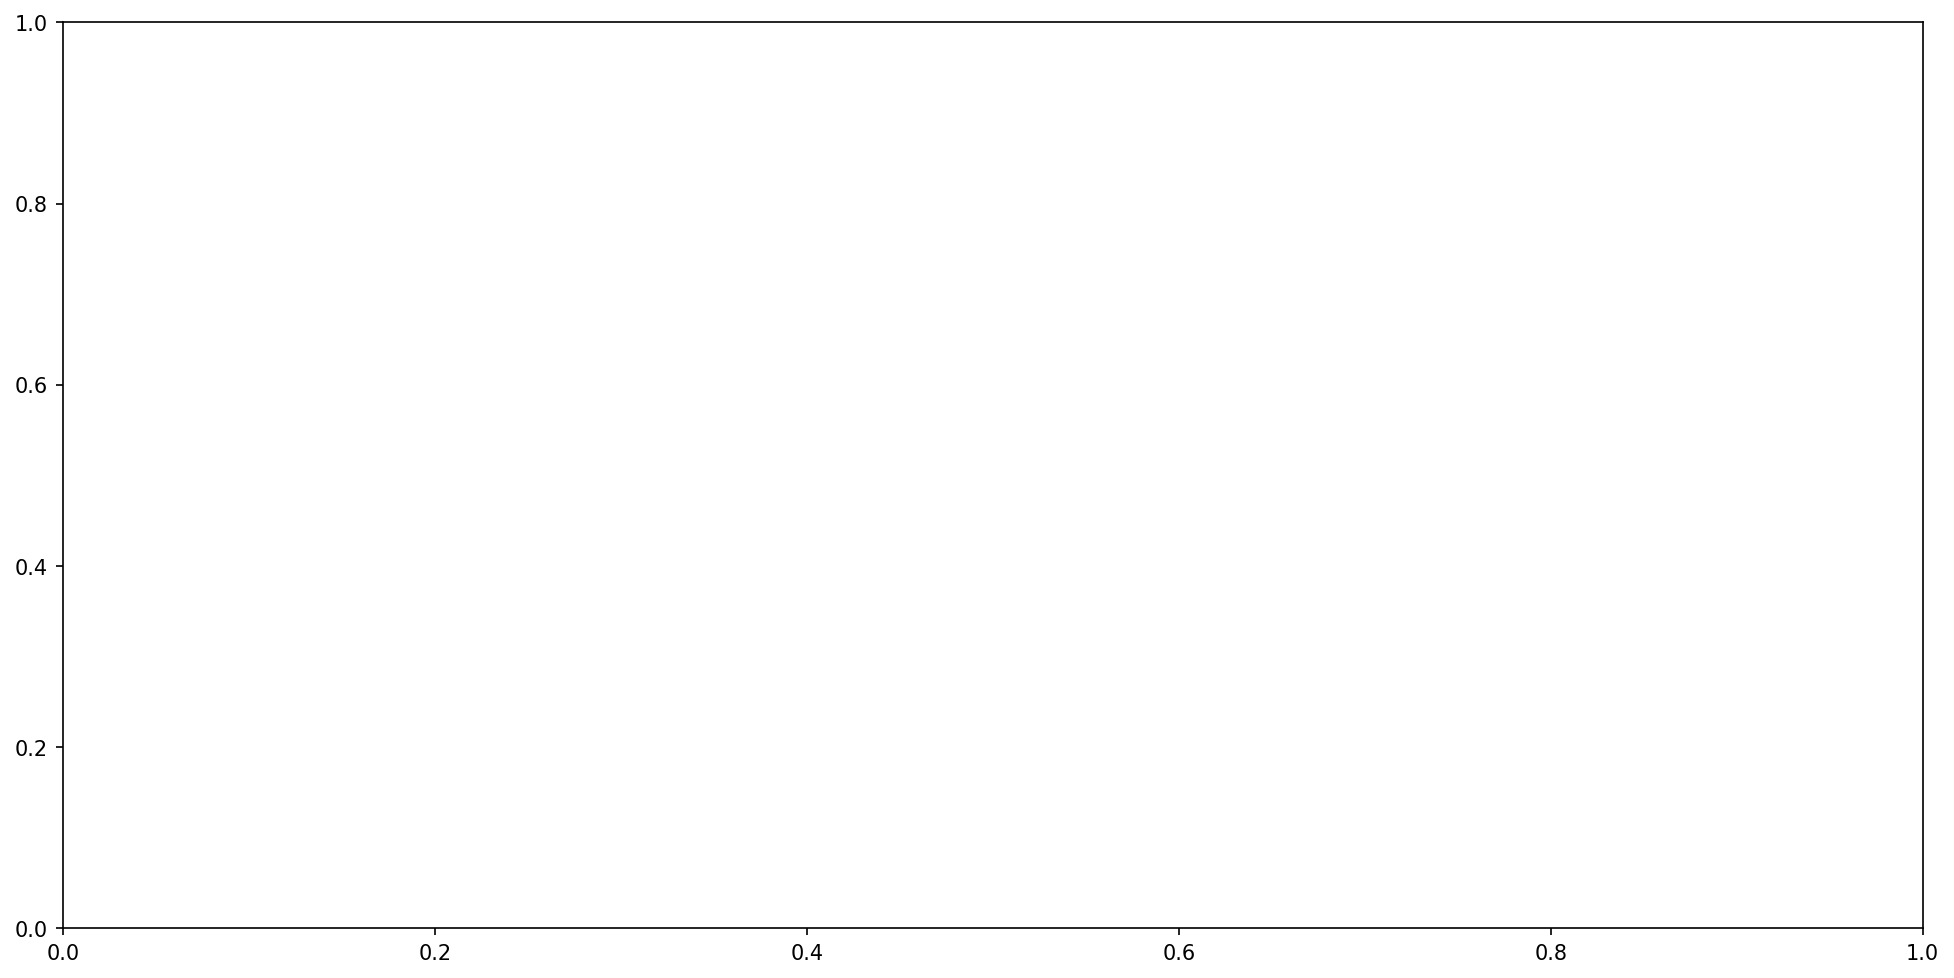

In [81]:
# code
# Visualizing The Open Price of all the stocks
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
synthetic_data['POL_NUMB'].plot(label='Number Of Switches', color='blue')
  
# adding title to the plot
plt.title('Fund switches per month')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

In [62]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
Switches_table   DataFrame              POL_NUMB  API_T<...>[102975 rows x 4 columns]
synthetic_data   DataFrame          POL_NUMB           <...>18527.459563     202205  


In [63]:
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total

27.75071840555521